In [2]:
import pyspark.sql as pyspark_sql
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
# SparkSession creation
spark = pyspark_sql.SparkSession.builder.appName("Data_Visualization").getOrCreate()

# Visualize before Data cleaning

In [5]:
all_data = spark.read.csv("../data/all_data.csv", header=True, inferSchema=True)

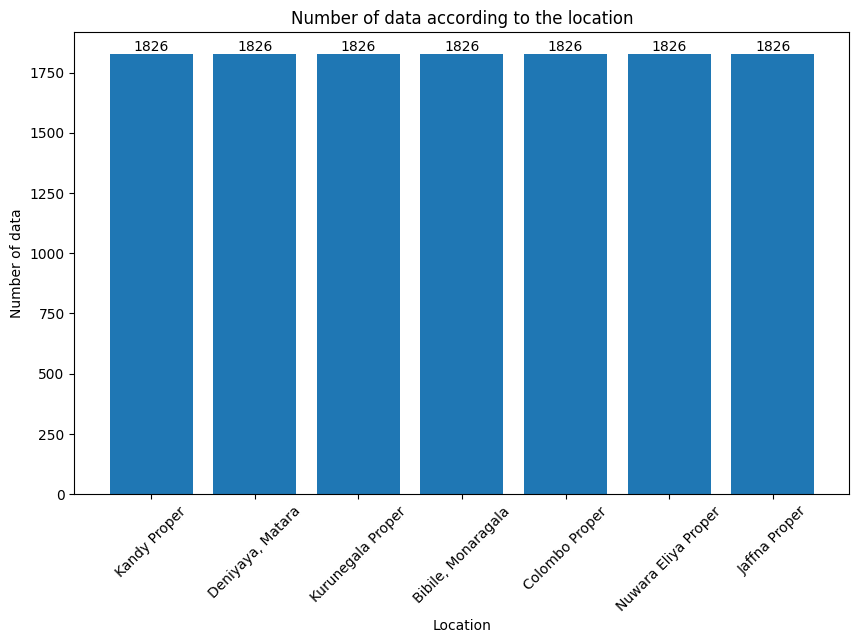

In [11]:
# Visualize a histogram of the number of data points according to location
location_count = all_data.groupBy("location").count().toPandas()

plt.figure(figsize=(10, 6))
plt.bar(location_count["location"], location_count["count"])
plt.xlabel("Location")
plt.ylabel("Number of data")
plt.title("Number of data according to the location")
plt.xticks(rotation=45)

# Add counts to each bar
for i, count in enumerate(location_count["count"]):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [6]:
# Group data by location and get the start date and end date
all_data.groupBy("location")\
    .agg(F.min("current_date").alias("start_date"),
         F.max("current_date").alias("end_date")).show()

+-------------------+----------+----------+
|           location|start_date|  end_date|
+-------------------+----------+----------+
|       Kandy Proper|2019-01-01|2023-12-31|
|   Deniyaya, Matara|2019-01-01|2023-12-31|
|  Kurunegala Proper|2019-01-01|2023-12-31|
| Bibile, Monaragala|2019-01-01|2023-12-31|
|     Colombo Proper|2019-01-01|2023-12-31|
|Nuwara Eliya Proper|2019-01-01|2023-12-31|
|      Jaffna Proper|2019-01-01|2023-12-31|
+-------------------+----------+----------+



##### Observation :

We have data available for the daily emission of formaldehyde(HCHO) gas from seven cities: Kandy, Matara(Deniyaya), Kurunegala, Monaragala(Bibile), Colombo, Nuwara Eliya, and Jaffna. This dataset covers the period from January 1st, 2019, to December 31st, 2023, providing 1826 days of data for each city.

### Checking Null Values

In [7]:
# Number of null values in each column for entire dataset
all_data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in all_data.columns]).show()

+------------+--------+------------+---------+
|hcho_reading|location|current_date|next_date|
+------------+--------+------------+---------+
|        4864|       0|           0|        0|
+------------+--------+------------+---------+



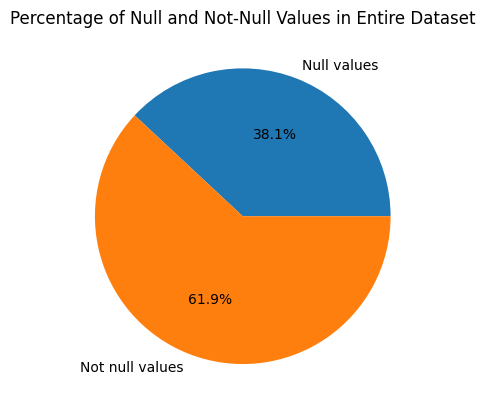

In [8]:
# Visulaize a pie chart with null values count for hcho_reading column in entire dataset
null_values_all = all_data.filter(F.col("hcho_reading").isNull()).count()
not_null_values_all = all_data.filter(F.col("hcho_reading").isNotNull()).count()

plt.pie([null_values_all, not_null_values_all], labels=["Null values", "Not null values"], autopct='%1.1f%%')
plt.title("Percentage of Null and Not-Null Values in Entire Dataset")
plt.show()

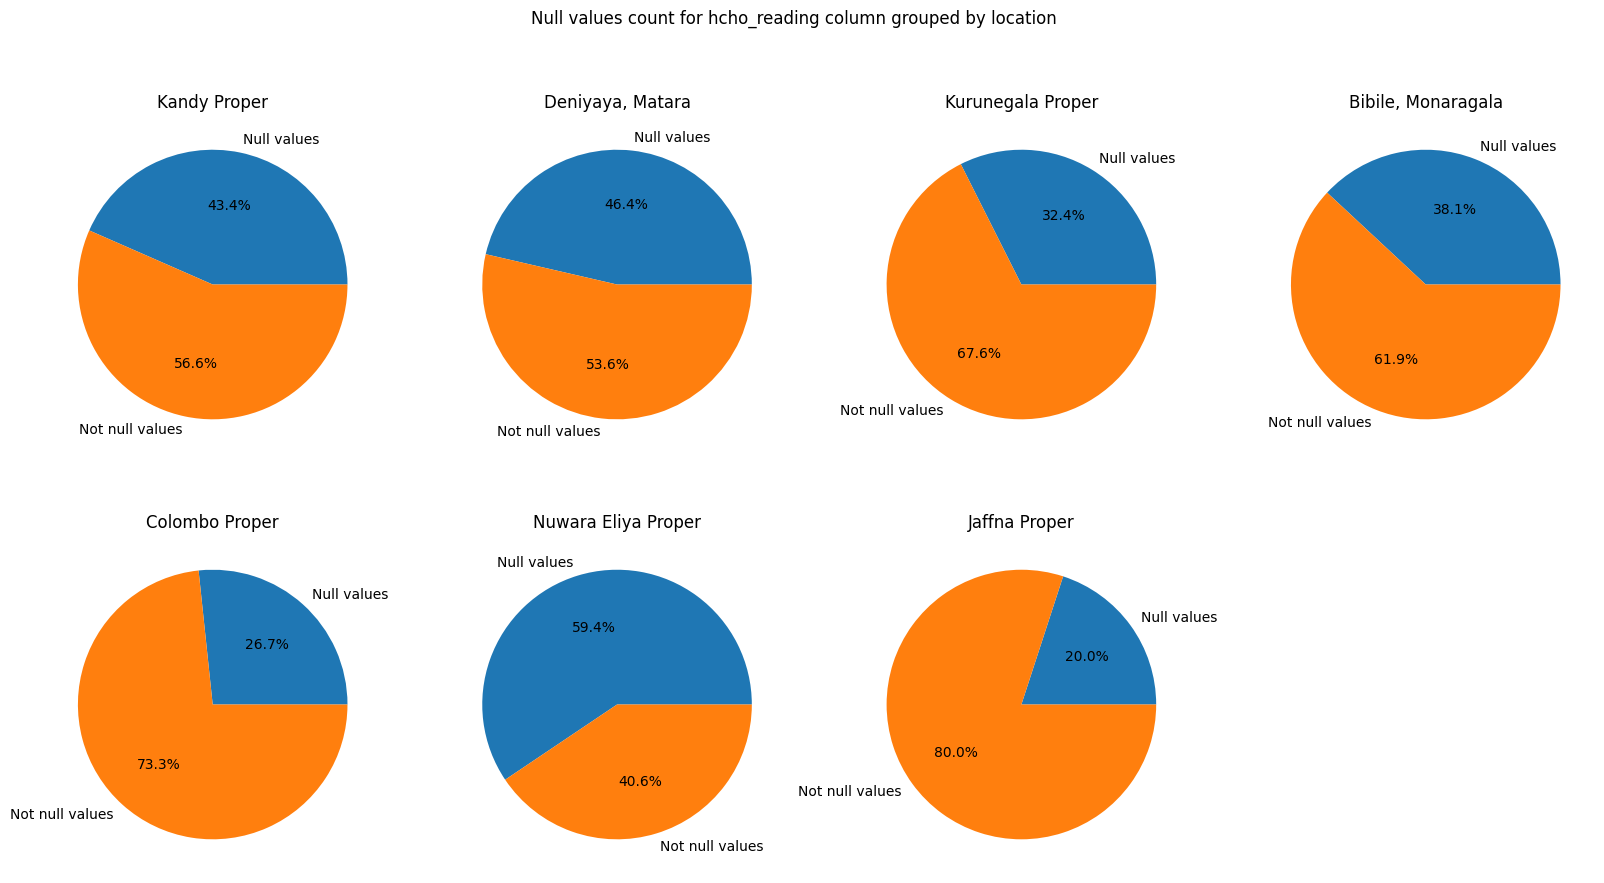

In [9]:
# Draw pie charts to look for null values grouped by location
null_values = all_data.filter(F.col("hcho_reading").isNull()).groupBy("location").count().toPandas()
not_null_values = all_data.filter(F.col("hcho_reading").isNotNull()).groupBy("location").count().toPandas()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Null values count for hcho_reading column grouped by location")

for i, ax in enumerate(axs.flat):
    if i < len(null_values):
        ax.pie([null_values["count"][i], not_null_values["count"][i]],
               labels=["Null values", "Not null values"], autopct='%1.1f%%')
        ax.set_title(null_values["location"][i])
    # Remove the last subplot
    else:
        fig.delaxes(ax)
    
plt.show()

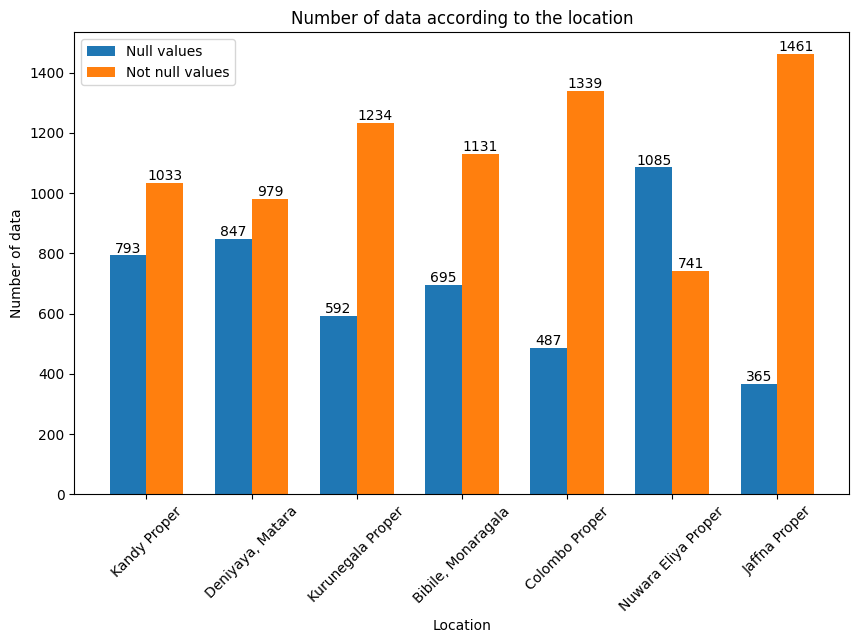

In [10]:
# Draw bar graph to visualize the distribution of null and not null values for each location
plt.figure(figsize=(10, 6))

# Set the x coordinates for the bars
x = np.arange(len(location_count["location"]))

# Plot the bars for null values
plt.bar(x - 0.35/2, null_values["count"], width=0.35, label='Null values')

# Plot the bars for not null values
plt.bar(x + 0.35/2, not_null_values["count"], width=0.35, label='Not null values')

plt.xlabel("Location")
plt.ylabel("Number of data")
plt.title("Number of data according to the location")
plt.xticks(x,location_count["location"],rotation=45)

# Add counts to each bar
for i, count in enumerate(location_count["count"]):
    plt.text(i - 0.35/2, null_values["count"][i], str(null_values["count"][i]), ha='center', va='bottom')
    plt.text(i + 0.35/2, not_null_values["count"][i], str(not_null_values["count"][i]), ha='center', va='bottom')

plt.legend()
plt.show()


##### Observation :

By studying the pie charts, null values account for more than 20% of the data in each city, and 38.1% of the entire dataset consists of null values. Dropping these null values is not a viable solution as it would result in significant data loss. Instead, we should explore alternative techniques for replacing missing values, such as utilizing various time series data imputation methods.

### Calculates statistics

In [11]:
# Describe the data for entire dataset only for "hcho_reading" column (count, mean, stddev, min, max, median)
all_data.select("hcho_reading").summary('count', 'mean', '50%', 'stddev', 'min', 'max').show(truncate=False)

+-------+---------------------+
|summary|hcho_reading         |
+-------+---------------------+
|count  |7918                 |
|mean   |1.1927789165137508E-4|
|50%    |1.1199156977987308E-4|
|stddev |9.322341209771862E-5 |
|min    |-3.524730243572399E-4|
|max    |8.997101837438971E-4 |
+-------+---------------------+



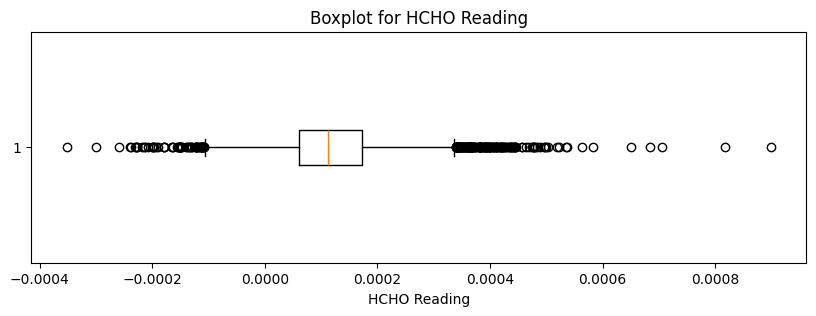

In [12]:
# Boxplot for hcho_reading column
hcho_reading = all_data.select("hcho_reading").toPandas()

plt.figure(figsize=(10, 3))
plt.boxplot(hcho_reading["hcho_reading"].dropna(), vert=False)
plt.xlabel("HCHO Reading")
plt.title("Boxplot for HCHO Reading")
plt.show()

In [13]:
# Describe the data for each city only for "hcho_reading" column
all_data.groupBy("location").agg(F.count("hcho_reading").alias("Not null values count"),
                                 F.mean("hcho_reading").alias("mean"),
                                 F.median("hcho_reading").alias("median"),
                                 F.stddev("hcho_reading").alias("standard deviation"),
                                 F.min("hcho_reading").alias("minimum value"),
                                 F.max("hcho_reading").alias("maximum value")).show(truncate=False)

+-------------------+---------------------+---------------------+---------------------+--------------------+----------------------+--------------------+
|location           |Not null values count|mean                 |median               |standard deviation  |minimum value         |maximum value       |
+-------------------+---------------------+---------------------+---------------------+--------------------+----------------------+--------------------+
|Kandy Proper       |1033                 |1.0637609562088451E-4|1.0591336505792406E-4|9.202571862518035E-5|-2.9970286313519965E-4|7.051621763962024E-4|
|Deniyaya, Matara   |979                  |9.165608034246397E-5 |8.139267673429977E-5 |9.717767267758977E-5|-2.592961765526682E-4 |8.997101837438971E-4|
|Kurunegala Proper  |1234                 |1.340202702666862E-4 |1.2690397565191832E-4|8.677375232539984E-5|-1.5709375930591097E-4|5.032967399339503E-4|
|Bibile, Monaragala |1131                 |1.2643137974120453E-4|1.245459857616176

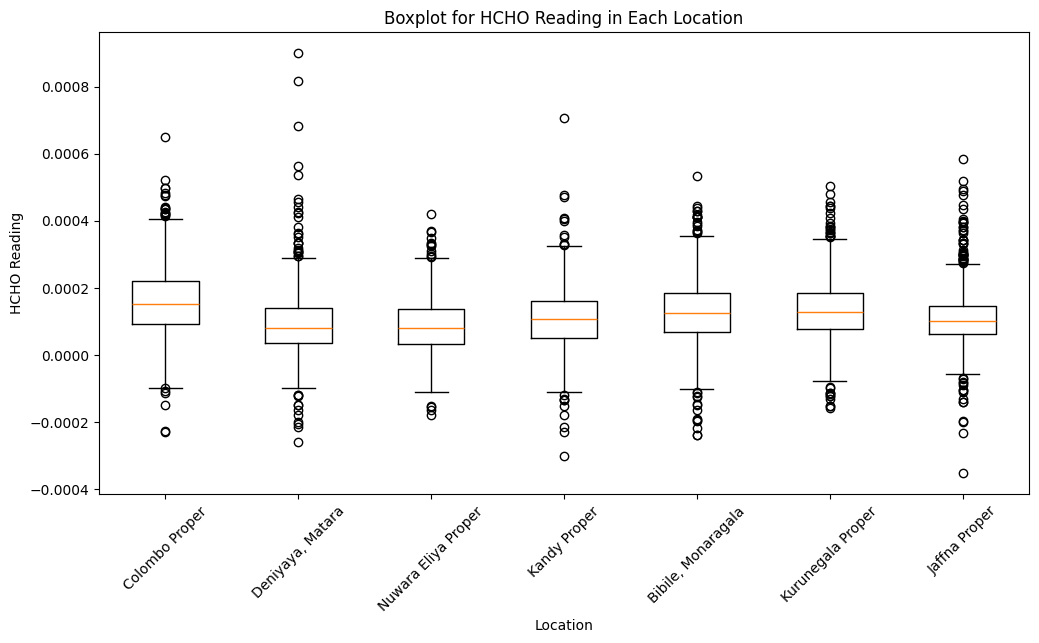

In [14]:
# Plot the boxplot for each city
location_hcho_reading = all_data.select("location", "hcho_reading").toPandas()
locations = location_hcho_reading['location'].unique()

plt.figure(figsize=(12, 6))
plt.boxplot([location_hcho_reading[location_hcho_reading["location"] == location]["hcho_reading"].dropna() for location in locations])
plt.xlabel("Location")
plt.ylabel("HCHO Reading")
plt.title("Boxplot for HCHO Reading in Each Location")
plt.xticks(range(1, len(locations)+1), locations, rotation=45)
plt.show()

In [15]:
# Get the number of negative values in hcho_reading column
negative_values = all_data.filter(F.col("hcho_reading") < 0).count()
print(f"Number of negative values in hcho_reading column: {negative_values}")

Number of negative values in hcho_reading column: 563


##### Observation :

Looking at the boxplots, we notice there are negative values present in the dataset. Formaldehyde levels are usually measured in parts per million (ppm) or micrograms per cubic meter (µg/m³), indicating the amount of formaldehyde in the air. Since formaldehyde is a substance that can only be present or absent in a given volume of air, it cannot have negative values. Any negative readings would be considered invalid or erroneous data. Hence, these negative readings should be replaced with null values.

## Plot Time Series Graphs before handling missing values for each city

#### 1. Kandy Proper

In [24]:
# Read kandy proper csv file
kandy_proper = spark.read.csv("../data/location/kandy_proper.csv", header=True, inferSchema=True)\
    .select("current_date", "hcho_reading").toPandas()

In [25]:
# Convert the current_date column to datetime
kandy_proper["current_date"] = pd.to_datetime(kandy_proper["current_date"])

In [26]:
# Set date as index
kandy_proper.set_index("current_date", inplace=True, drop=True)

In [27]:
kandy_proper.head()

,hcho_reading
current_date,
2019-01-01,0.000176
2019-01-02,0.000092
2019-01-03,NaN
2019-01-04,0.000191
2019-01-05,0.000122


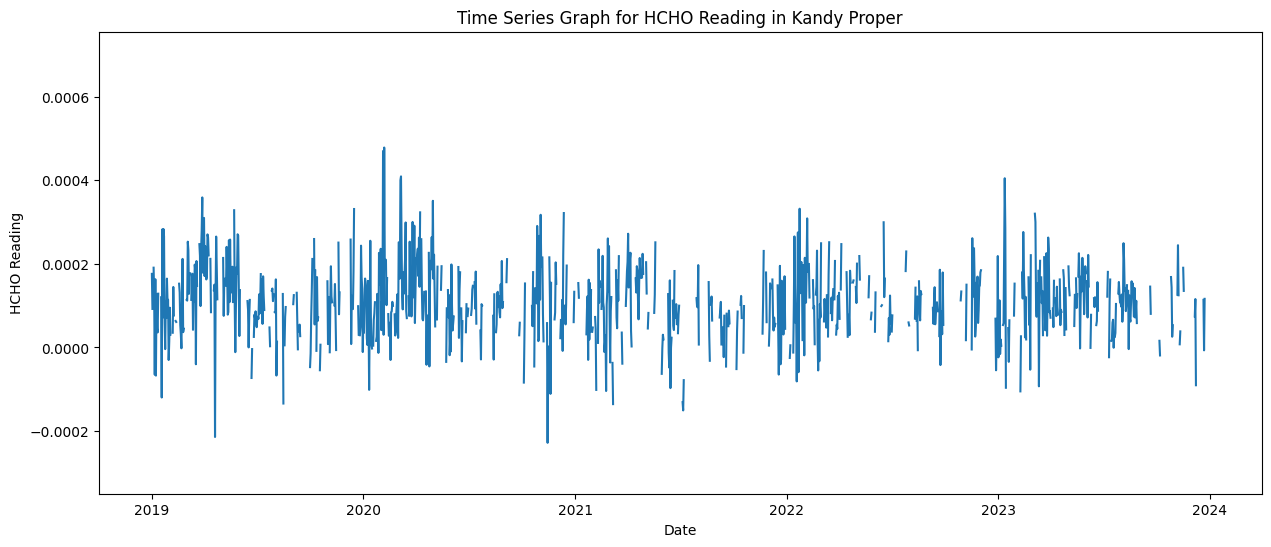

In [28]:
# Plot the time series graph for hcho_reading in Kandy Proper
plt.figure(figsize=(15, 6))
plt.plot(kandy_proper.index, kandy_proper["hcho_reading"])
plt.xlabel("Date")
plt.ylabel("HCHO Reading")
plt.title("Time Series Graph for HCHO Reading in Kandy Proper")
plt.show()

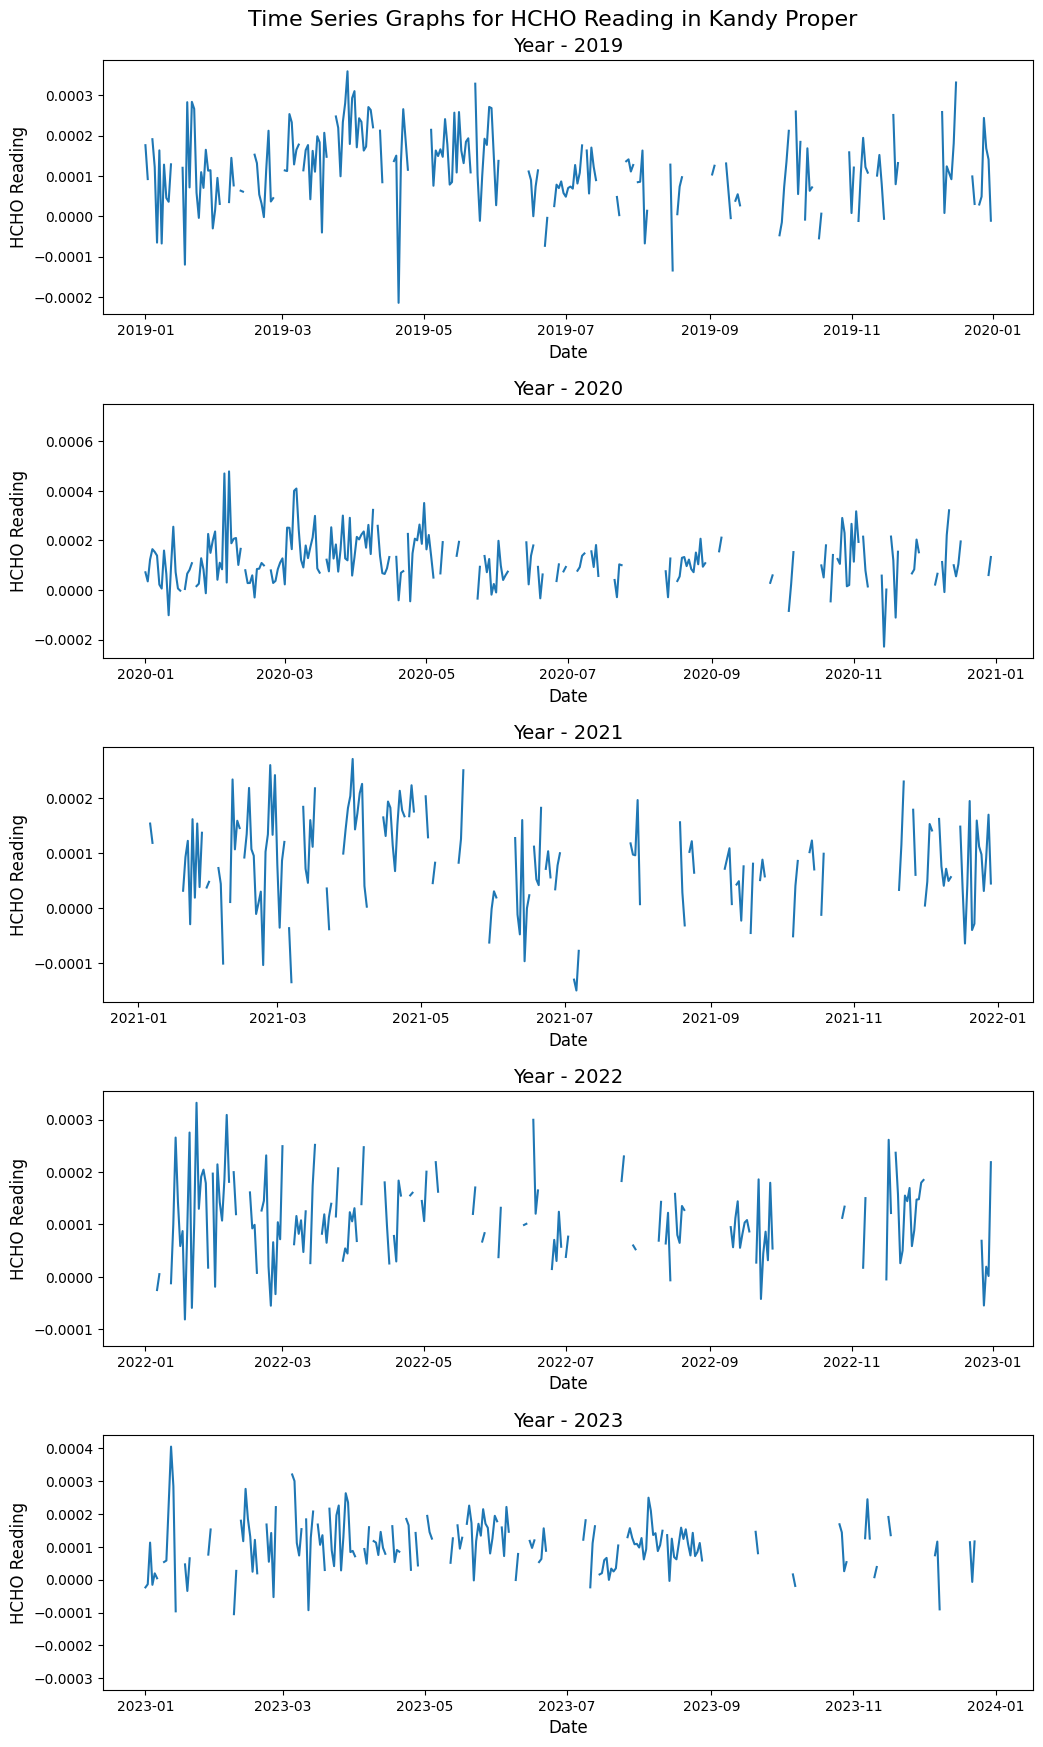

In [40]:
# Plot the time series graph for hcho_reading in Kandy Proper for each year
years = [2019, 2020, 2021, 2022, 2023]

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle("Time Series Graphs for HCHO Reading in Kandy Proper", y=0.95, fontsize=16)

for year in years:
    axs[year-2019].plot(kandy_proper.loc[f"{year}-01-01":f"{year}-12-31"].index, 
                        kandy_proper.loc[f"{year}-01-01":f"{year}-12-31"]["hcho_reading"])
    axs[year-2019].set_title(f"Year - {year}", fontsize=14)
    axs[year-2019].set_xlabel("Date", fontsize=12)
    axs[year-2019].set_ylabel("HCHO Reading", fontsize=12)

# Adjust the spacing between supertitle and subtitles
plt.subplots_adjust(top=0.925, hspace=0.35)
plt.show()

#### 2. Colombo Proper

In [41]:
# Read colombo proper csv file
colombo_proper = spark.read.csv("../data/location/colombo_proper.csv", header=True, inferSchema=True)\
    .select("current_date", "hcho_reading").toPandas()

In [42]:
# Convert the current_date column to datetime
colombo_proper["current_date"] = pd.to_datetime(colombo_proper["current_date"])

In [44]:
# Set date as index
colombo_proper.set_index("current_date", inplace=True, drop=True)

In [45]:
colombo_proper.head()

,hcho_reading
current_date,
2019-01-01,0.000197
2019-01-02,0.000263
2019-01-03,0.000099
2019-01-04,0.000210
2019-01-05,0.000179


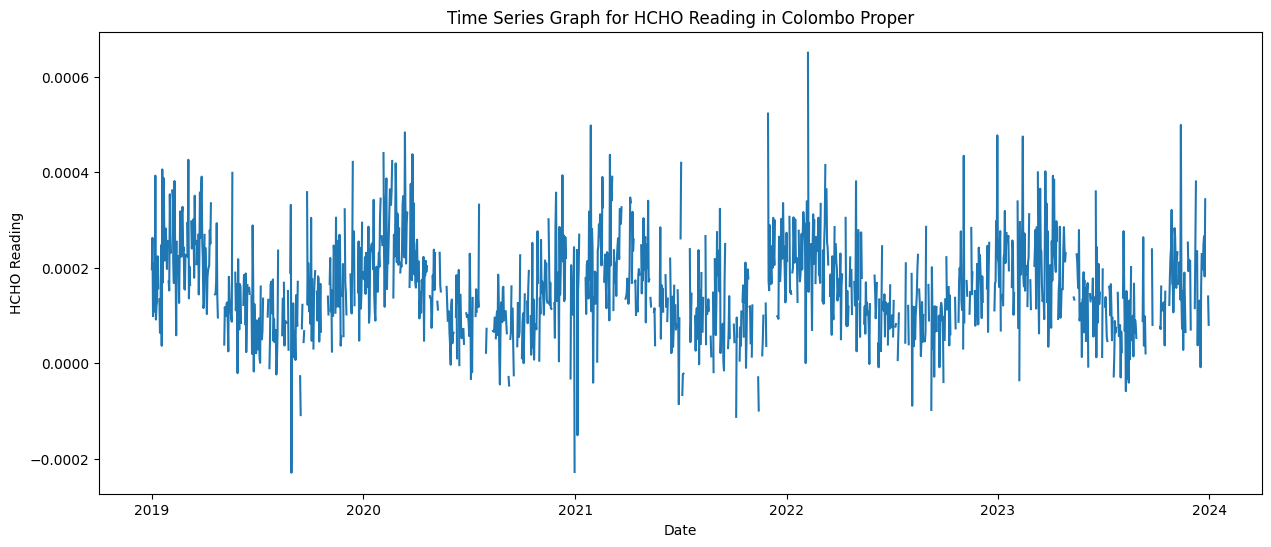

In [46]:
# Plot the time series graph for hcho_reading in Colombo Proper
plt.figure(figsize=(15, 6))
plt.plot(colombo_proper.index, colombo_proper["hcho_reading"])
plt.xlabel("Date")
plt.ylabel("HCHO Reading")
plt.title("Time Series Graph for HCHO Reading in Colombo Proper")
plt.show()

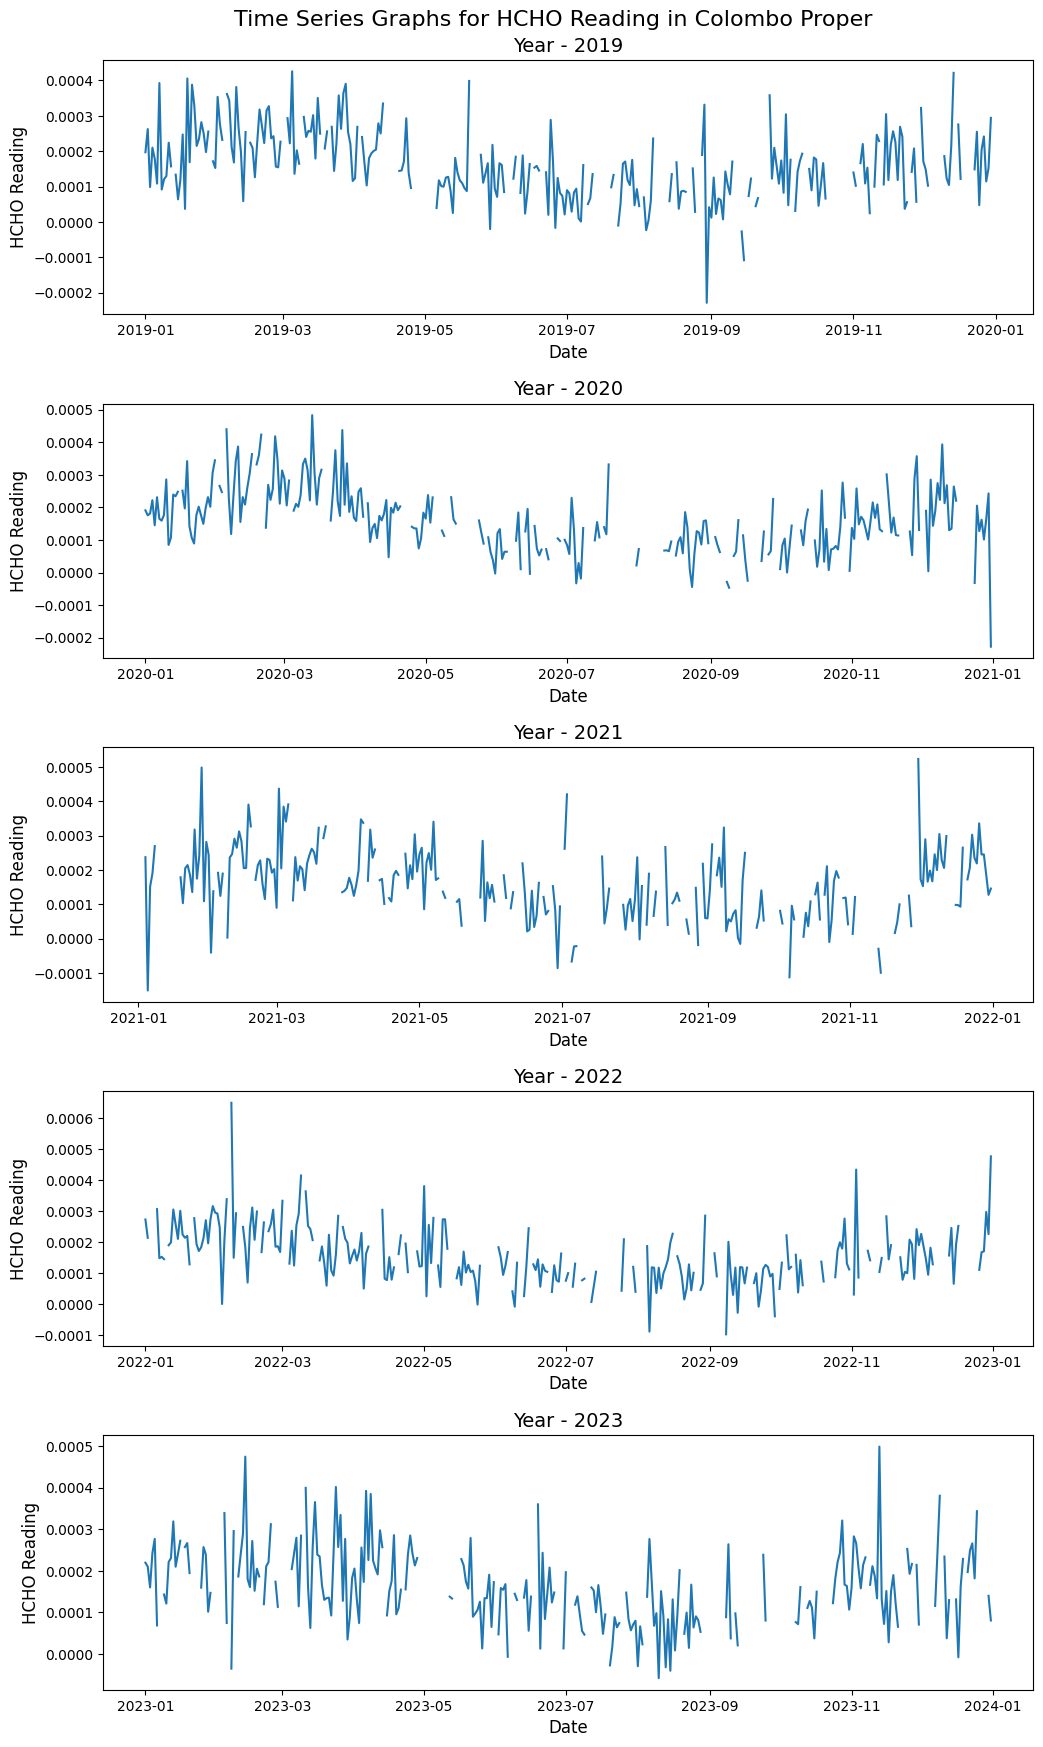

In [48]:
# Plot the time series graph for hcho_reading in Colombo Proper for each year

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle("Time Series Graphs for HCHO Reading in Colombo Proper", y=0.95, fontsize=16)

for year in years:
    axs[year-2019].plot(colombo_proper.loc[f"{year}-01-01":f"{year}-12-31"].index, 
                        colombo_proper.loc[f"{year}-01-01":f"{year}-12-31"]["hcho_reading"])
    axs[year-2019].set_title(f"Year - {year}", fontsize=14)
    axs[year-2019].set_xlabel("Date", fontsize=12)
    axs[year-2019].set_ylabel("HCHO Reading", fontsize=12)

# Adjust the spacing between supertitle and subtitles
plt.subplots_adjust(top=0.925, hspace=0.35)
plt.show()

#### 3. Jaffna Proper

In [4]:
# Read jaffna proper csv file
jaffna_proper = spark.read.csv("../data/location/jaffna_proper.csv", header=True, inferSchema=True)\
    .select("current_date", "hcho_reading").toPandas()

In [5]:
# Convert the current_date column to datetime
jaffna_proper["current_date"] = pd.to_datetime(jaffna_proper["current_date"])

In [6]:
# Set date as index
jaffna_proper.set_index("current_date", inplace=True, drop=True)

In [7]:
jaffna_proper.head()

,hcho_reading
current_date,
2019-01-01,0.000058
2019-01-02,0.000102
2019-01-03,0.000039
2019-01-04,-0.000002
2019-01-05,0.000159


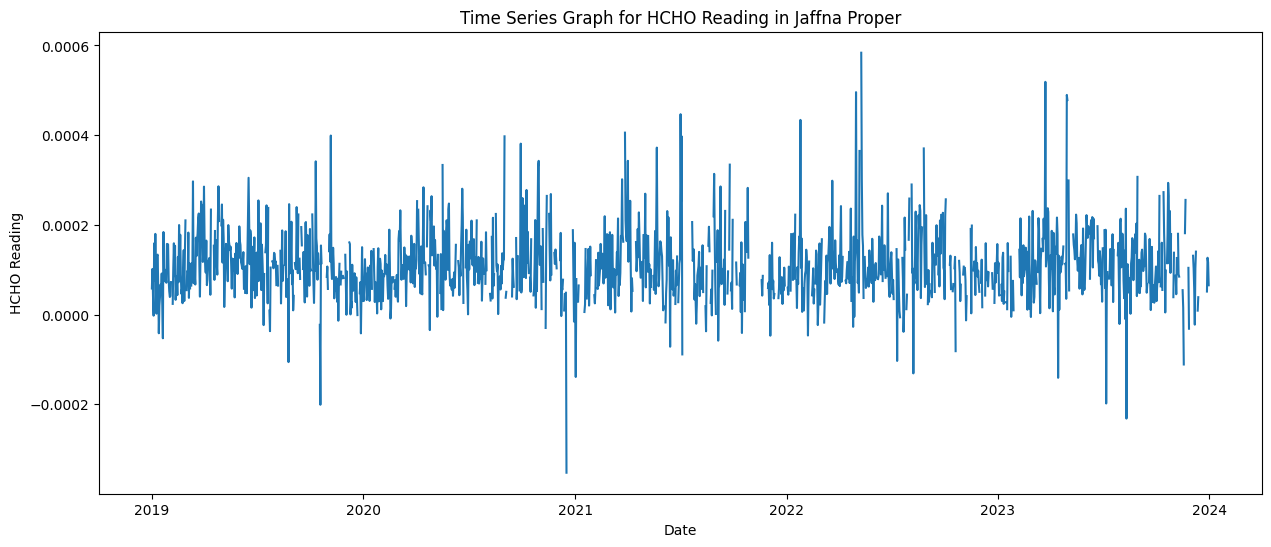

In [8]:
# Plot the time series graph for hcho_reading in Jaffna Proper
plt.figure(figsize=(15, 6))
plt.plot(jaffna_proper.index, jaffna_proper["hcho_reading"])
plt.xlabel("Date")
plt.ylabel("HCHO Reading")
plt.title("Time Series Graph for HCHO Reading in Jaffna Proper")
plt.show()

In [9]:
years = [2019, 2020, 2021, 2022, 2023]

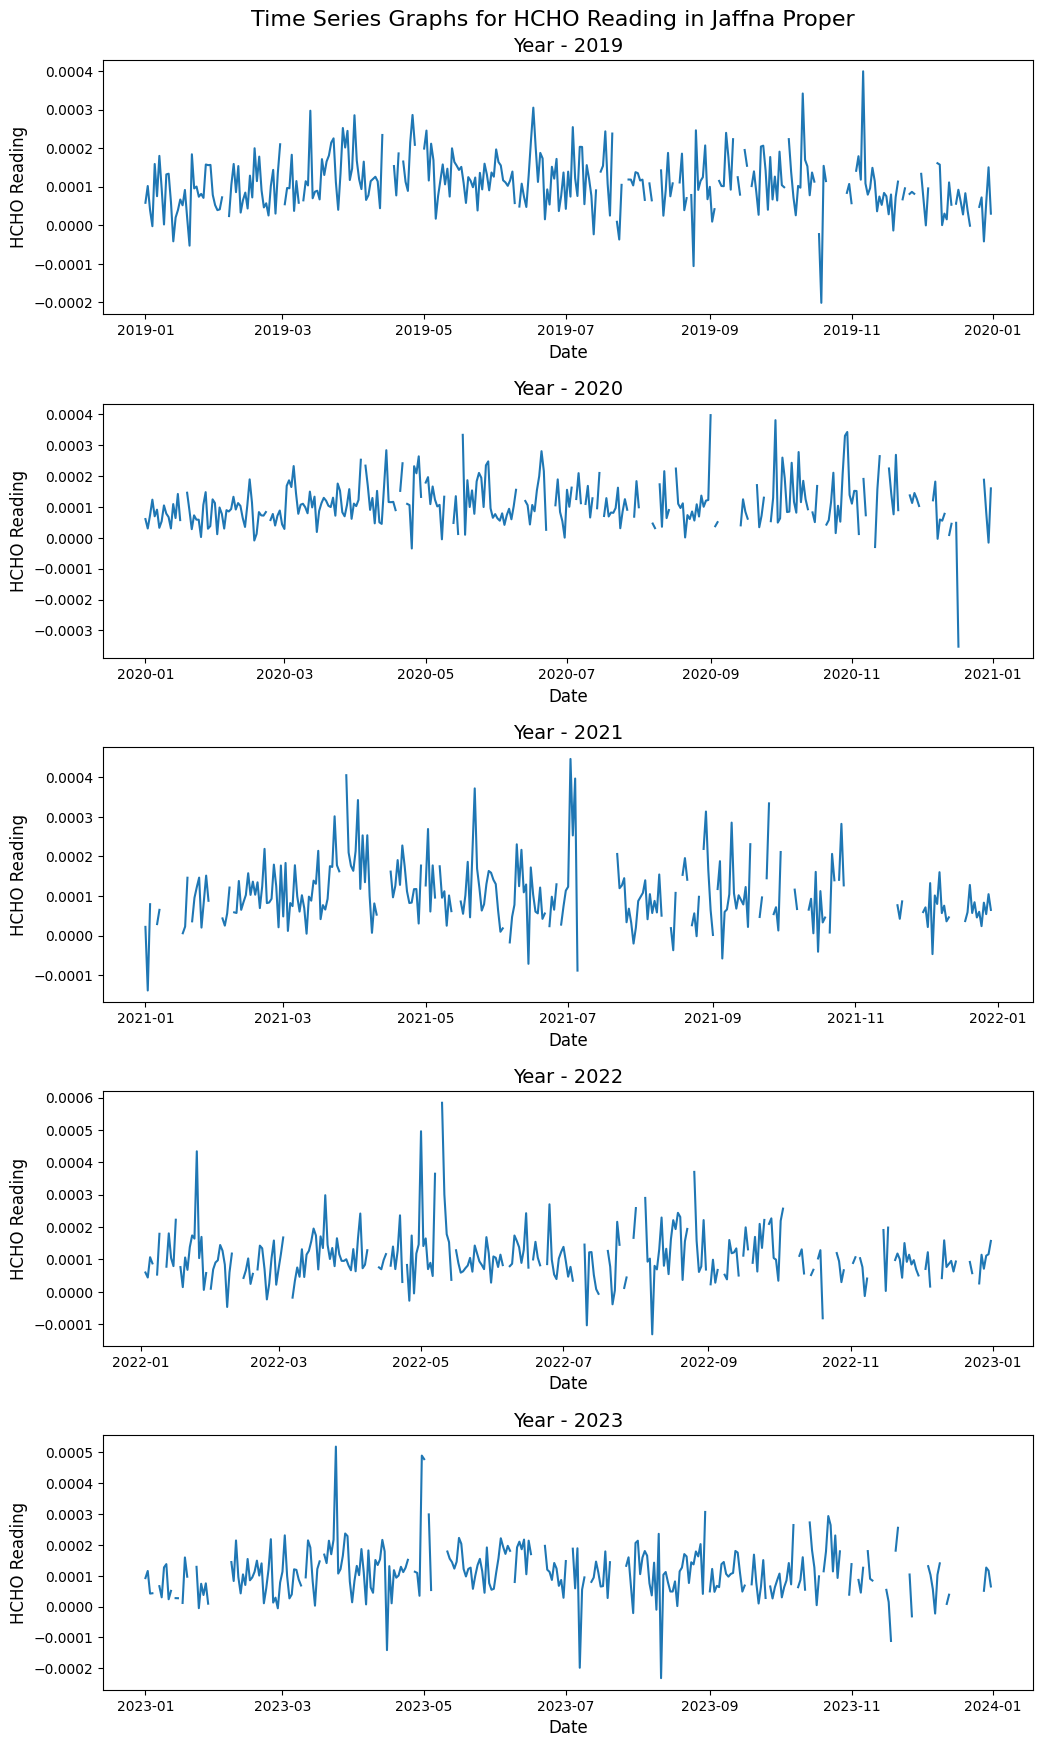

In [10]:
# Plot the time series graph for hcho_reading in Jaffna Proper for each year

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle("Time Series Graphs for HCHO Reading in Jaffna Proper", y=0.95, fontsize=16)

for year in years:
    axs[year-2019].plot(jaffna_proper.loc[f"{year}-01-01":f"{year}-12-31"].index, 
                        jaffna_proper.loc[f"{year}-01-01":f"{year}-12-31"]["hcho_reading"])
    axs[year-2019].set_title(f"Year - {year}", fontsize=14)
    axs[year-2019].set_xlabel("Date", fontsize=12)
    axs[year-2019].set_ylabel("HCHO Reading", fontsize=12)

# Adjust the spacing between supertitle and subtitles
plt.subplots_adjust(top=0.925, hspace=0.35)
plt.show()

#### 4. Kurunegala Proper

In [11]:
# Read Kurunegala proper csv file
kurunegala_proper = spark.read.csv("../data/location/kurunegala_proper.csv", header=True, inferSchema=True)\
    .select("current_date", "hcho_reading").toPandas()

In [12]:
# Convert the current_date column to datetime
kurunegala_proper["current_date"] = pd.to_datetime(kurunegala_proper["current_date"])

In [13]:
# Set date as index
kurunegala_proper.set_index("current_date", inplace=True, drop=True)

In [14]:
kurunegala_proper.head()

,hcho_reading
current_date,
2019-01-01,0.000088
2019-01-02,0.000137
2019-01-03,0.000148
2019-01-04,-0.000002
2019-01-05,0.000249


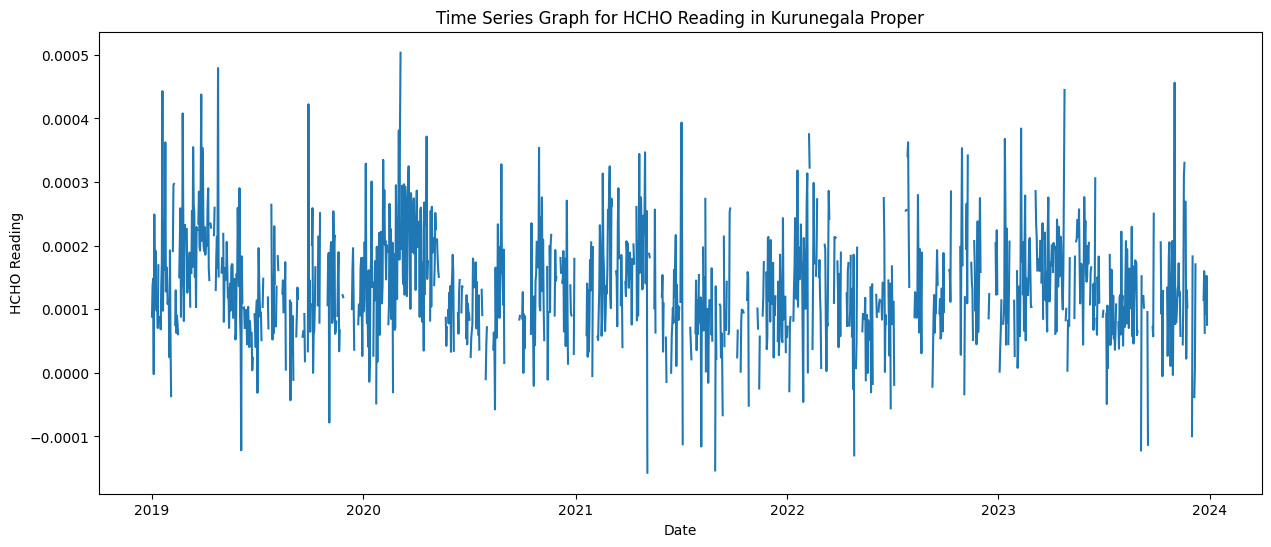

In [15]:
# Plot the time series graph for hcho_reading in Kurunegala Proper
plt.figure(figsize=(15, 6))
plt.plot(kurunegala_proper.index, kurunegala_proper["hcho_reading"])
plt.xlabel("Date")
plt.ylabel("HCHO Reading")
plt.title("Time Series Graph for HCHO Reading in Kurunegala Proper")
plt.show()

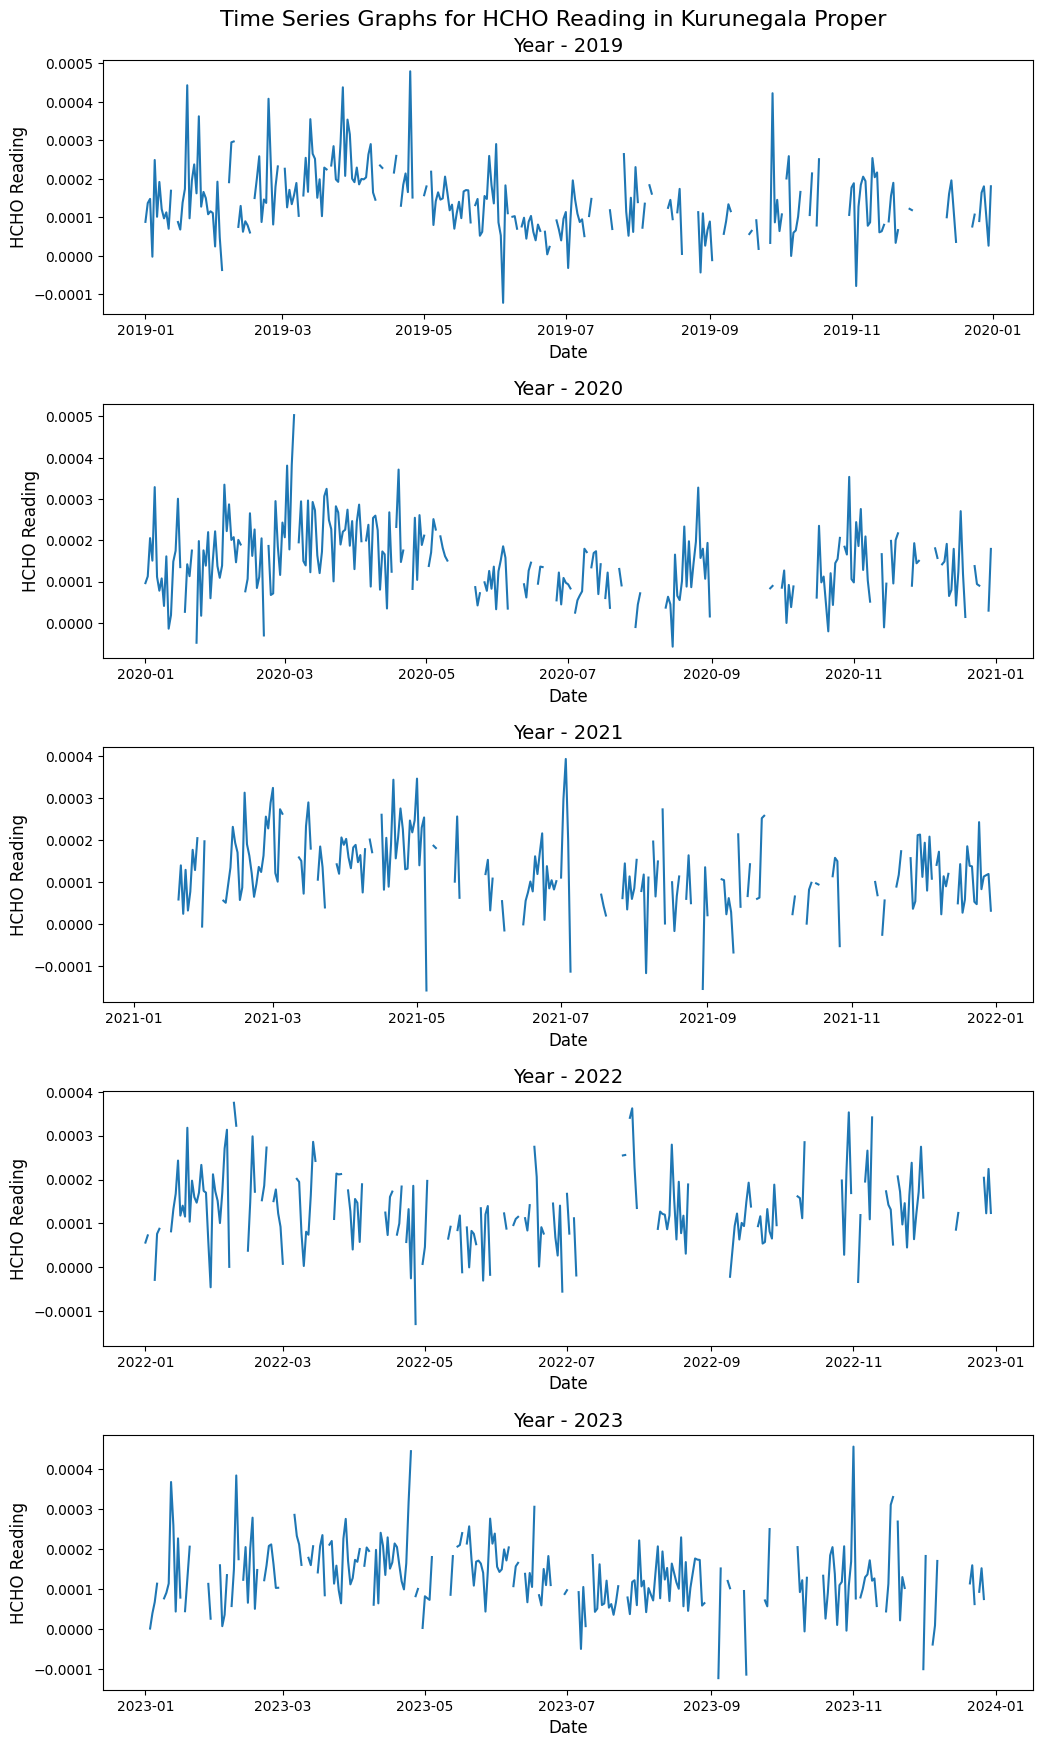

In [16]:
# Plot the time series graph for hcho_reading in Kurunegala Proper for each year

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle("Time Series Graphs for HCHO Reading in Kurunegala Proper", y=0.95, fontsize=16)

for year in years:
    axs[year-2019].plot(kurunegala_proper.loc[f"{year}-01-01":f"{year}-12-31"].index,
                        kurunegala_proper.loc[f"{year}-01-01":f"{year}-12-31"]["hcho_reading"])
    axs[year-2019].set_title(f"Year - {year}", fontsize=14)
    axs[year-2019].set_xlabel("Date", fontsize=12)
    axs[year-2019].set_ylabel("HCHO Reading", fontsize=12)

# Adjust the spacing between supertitle and subtitles
plt.subplots_adjust(top=0.925, hspace=0.35)
plt.show()

#### 5. Nuwara Eliya Proper

In [17]:
# Read Nuwara Eliya proper csv file
ne_proper = spark.read.csv("../data/location/nuwaraeliya_proper.csv", header=True, inferSchema=True)\
    .select("current_date", "hcho_reading").toPandas()

In [18]:
# Convert the current_date column to datetime
ne_proper["current_date"] = pd.to_datetime(ne_proper["current_date"])

In [19]:
# Set date as index
ne_proper.set_index("current_date", inplace=True, drop=True)

In [20]:
ne_proper.head()

,hcho_reading
current_date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,0.000191
2019-01-04,0.000051
2019-01-05,0.000065


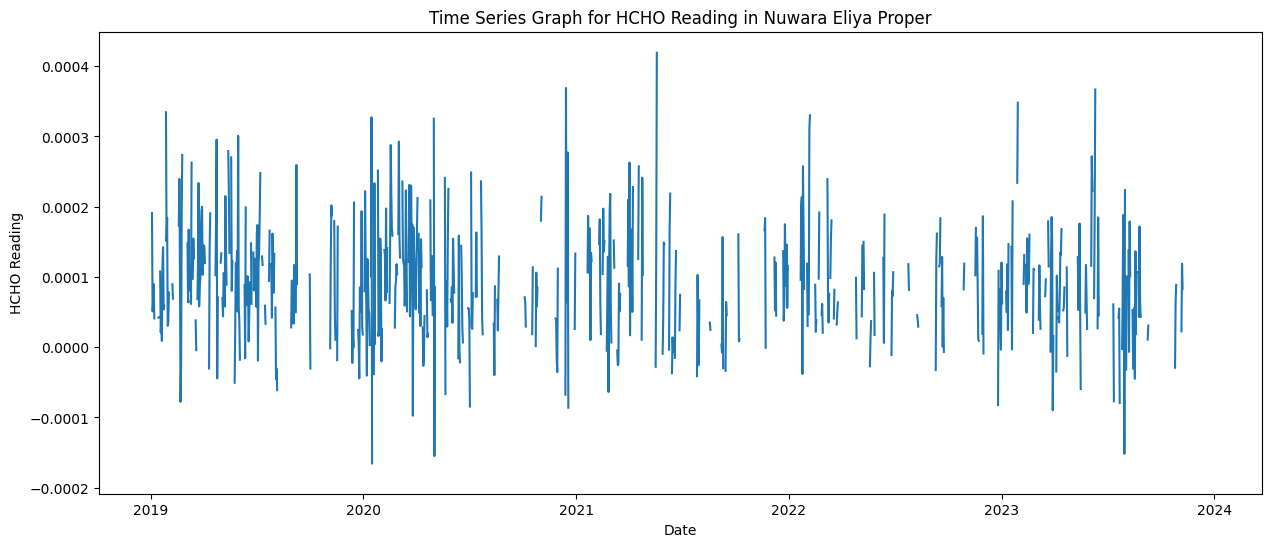

In [21]:
# Plot the time series graph for hcho_reading in Nuwara Eliya Proper
plt.figure(figsize=(15, 6))
plt.plot(ne_proper.index, ne_proper["hcho_reading"])
plt.xlabel("Date")
plt.ylabel("HCHO Reading")
plt.title("Time Series Graph for HCHO Reading in Nuwara Eliya Proper")
plt.show()

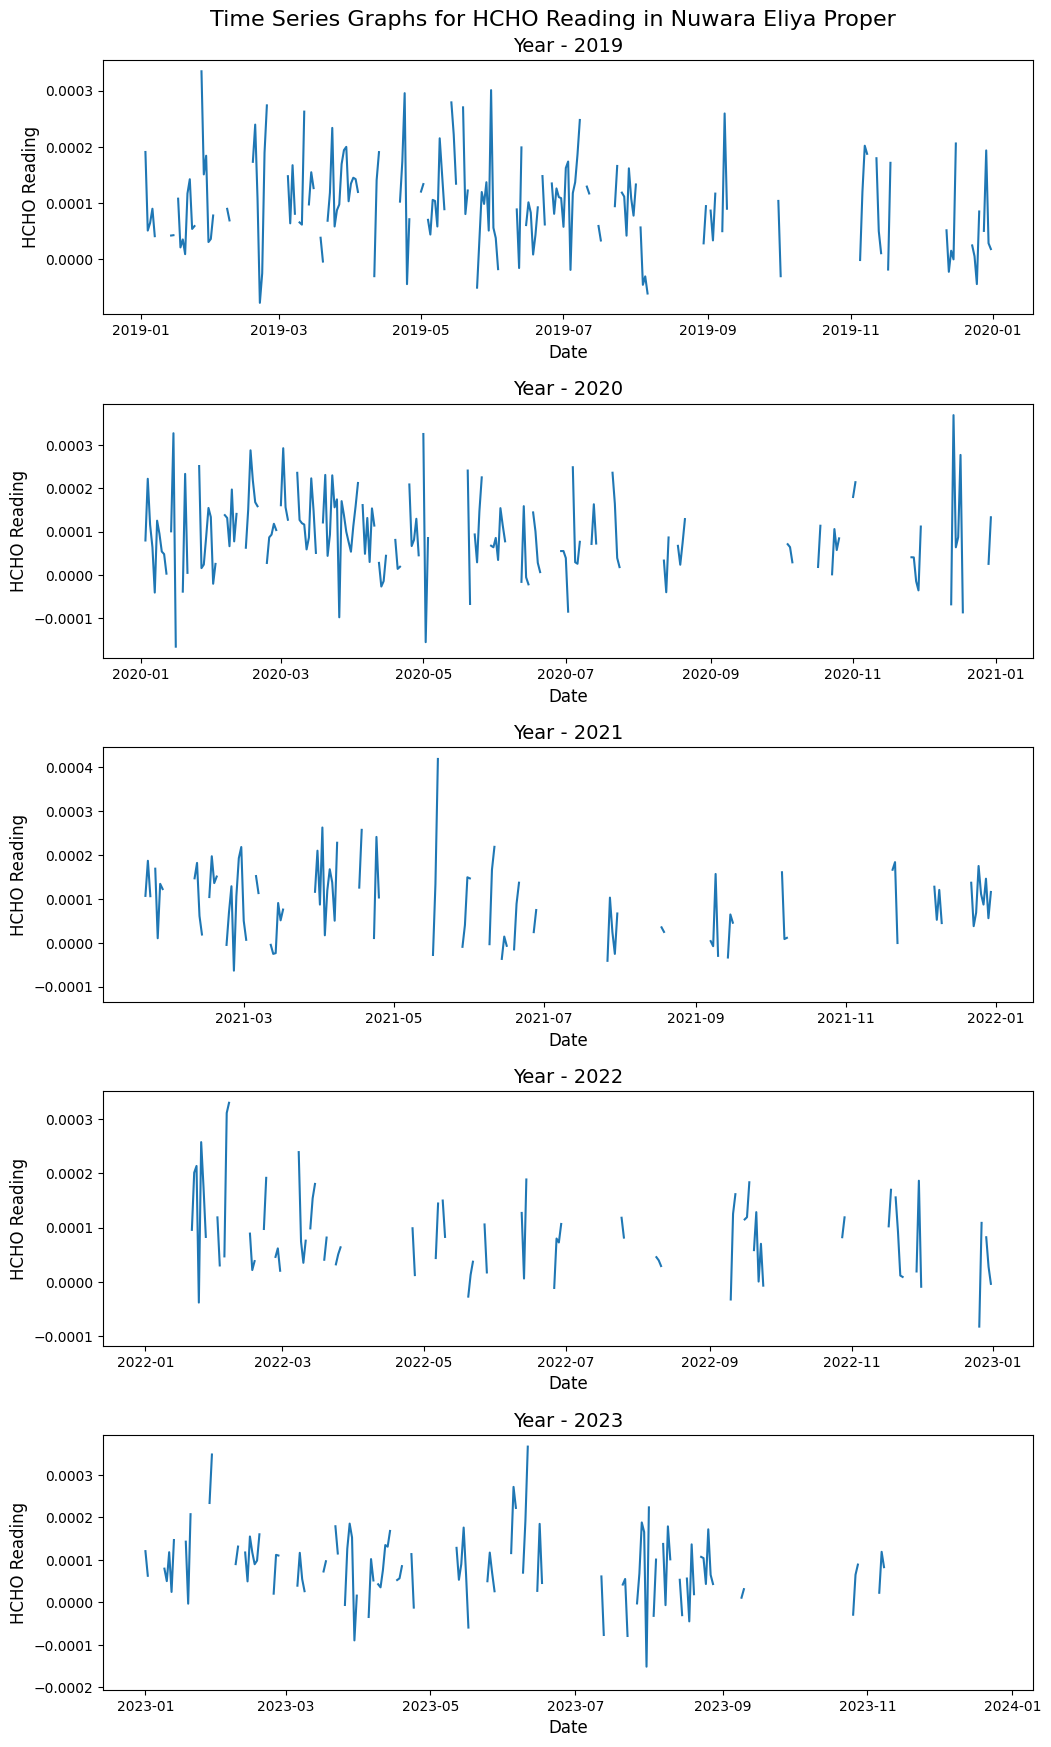

In [22]:
# Plot the time series graph for hcho_reading in Nuwara Eliya Proper for each year

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle("Time Series Graphs for HCHO Reading in Nuwara Eliya Proper", y=0.95, fontsize=16)

for year in years:
    axs[year-2019].plot(ne_proper.loc[f"{year}-01-01":f"{year}-12-31"].index,
                        ne_proper.loc[f"{year}-01-01":f"{year}-12-31"]["hcho_reading"])
    axs[year-2019].set_title(f"Year - {year}", fontsize=14)
    axs[year-2019].set_xlabel("Date", fontsize=12)
    axs[year-2019].set_ylabel("HCHO Reading", fontsize=12)

# Adjust the spacing between supertitle and subtitles
plt.subplots_adjust(top=0.925, hspace=0.35)
plt.show()

#### 6. Bibile, Monaraagala

In [23]:
# Read Bibile, Monaraagala csv file
bibile_proper = spark.read.csv("../data/location/bibile_monaragala.csv", header=True, inferSchema=True)\
    .select("current_date", "hcho_reading").toPandas()

In [24]:
# Convert the current_date column to datetime
bibile_proper["current_date"] = pd.to_datetime(bibile_proper["current_date"])

In [25]:
# Set date as index
bibile_proper.set_index("current_date", inplace=True, drop=True)

In [26]:
bibile_proper.head()

,hcho_reading
current_date,
2019-01-01,NaN
2019-01-02,0.000019
2019-01-03,0.000028
2019-01-04,0.000037
2019-01-05,-0.000018


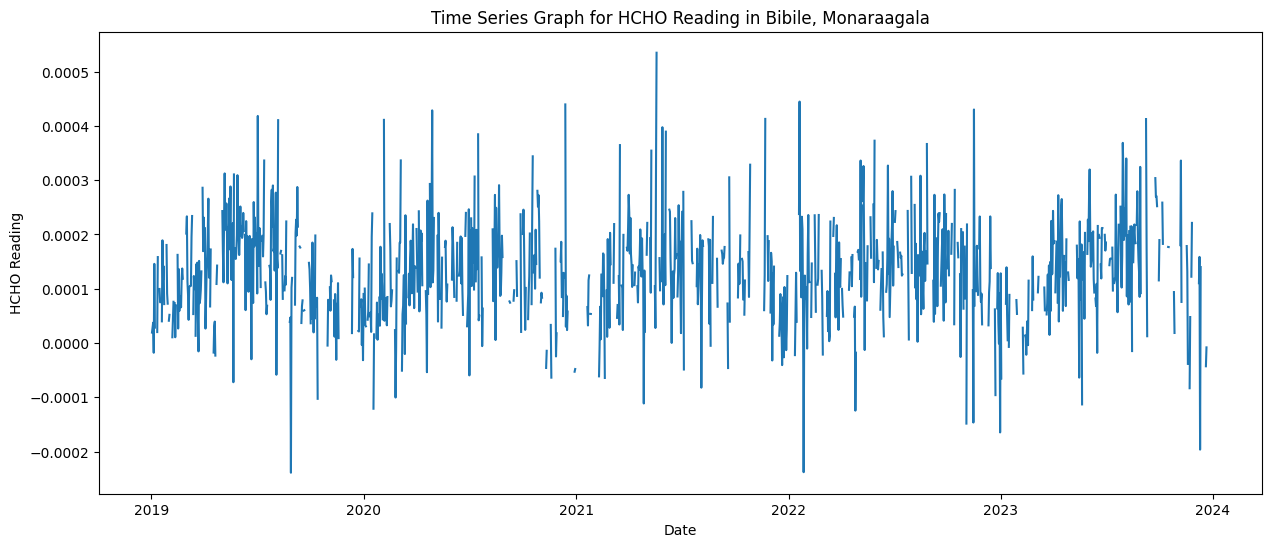

In [27]:
# Plot the time series graph for hcho_reading in Bibile, Monaraagala
plt.figure(figsize=(15, 6))
plt.plot(bibile_proper.index, bibile_proper["hcho_reading"])
plt.xlabel("Date")
plt.ylabel("HCHO Reading")
plt.title("Time Series Graph for HCHO Reading in Bibile, Monaraagala")
plt.show()

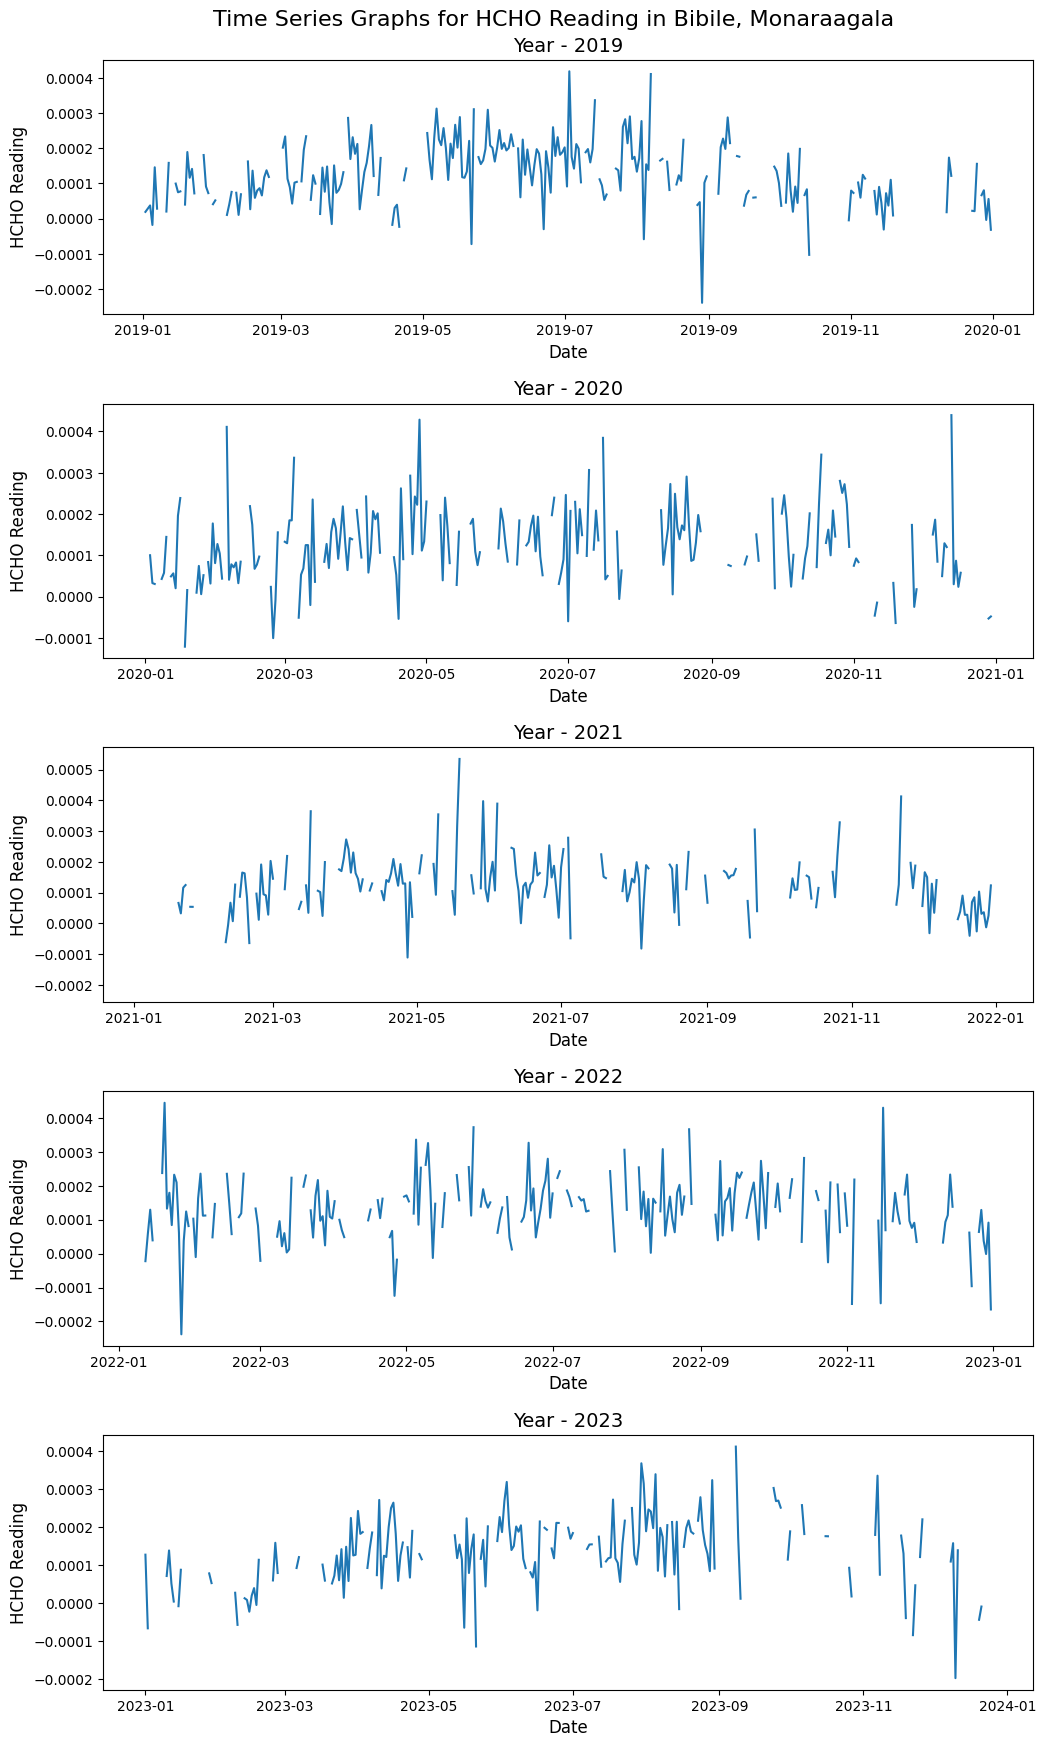

In [28]:
# Plot the time series graph for hcho_reading in Bibile, Monaraagala for each year

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle("Time Series Graphs for HCHO Reading in Bibile, Monaraagala", y=0.95, fontsize=16)

for year in years:
    axs[year-2019].plot(bibile_proper.loc[f"{year}-01-01":f"{year}-12-31"].index,
                        bibile_proper.loc[f"{year}-01-01":f"{year}-12-31"]["hcho_reading"])
    axs[year-2019].set_title(f"Year - {year}", fontsize=14)
    axs[year-2019].set_xlabel("Date", fontsize=12)
    axs[year-2019].set_ylabel("HCHO Reading", fontsize=12)

# Adjust the spacing between supertitle and subtitles
plt.subplots_adjust(top=0.925, hspace=0.35)
plt.show()

#### 7. Deniyaya, Matara

In [29]:
# Read Matara(Deniyaya) csv file
matara_proper = spark.read.csv("../data/location/deniyaya_matara.csv", header=True, inferSchema=True)\
    .select("current_date", "hcho_reading").toPandas()

In [30]:
# Convert the current_date column to datetime
matara_proper["current_date"] = pd.to_datetime(matara_proper["current_date"])

In [31]:
# Set date as index
matara_proper.set_index("current_date", inplace=True, drop=True)

In [32]:
matara_proper.head()

,hcho_reading
current_date,
2019-01-01,NaN
2019-01-02,0.000006
2019-01-03,0.000236
2019-01-04,0.000064
2019-01-05,0.000053


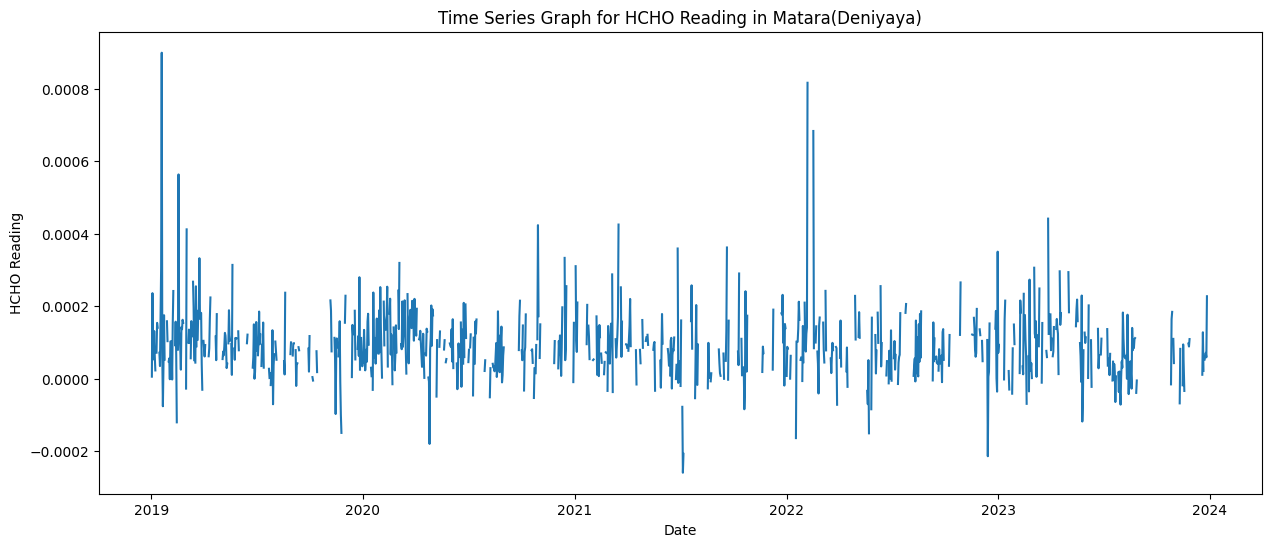

In [33]:
# Plot the time series graph for hcho_reading in Matara(Deniyaya)
plt.figure(figsize=(15, 6))
plt.plot(matara_proper.index, matara_proper["hcho_reading"])
plt.xlabel("Date")
plt.ylabel("HCHO Reading")
plt.title("Time Series Graph for HCHO Reading in Matara(Deniyaya)")
plt.show()

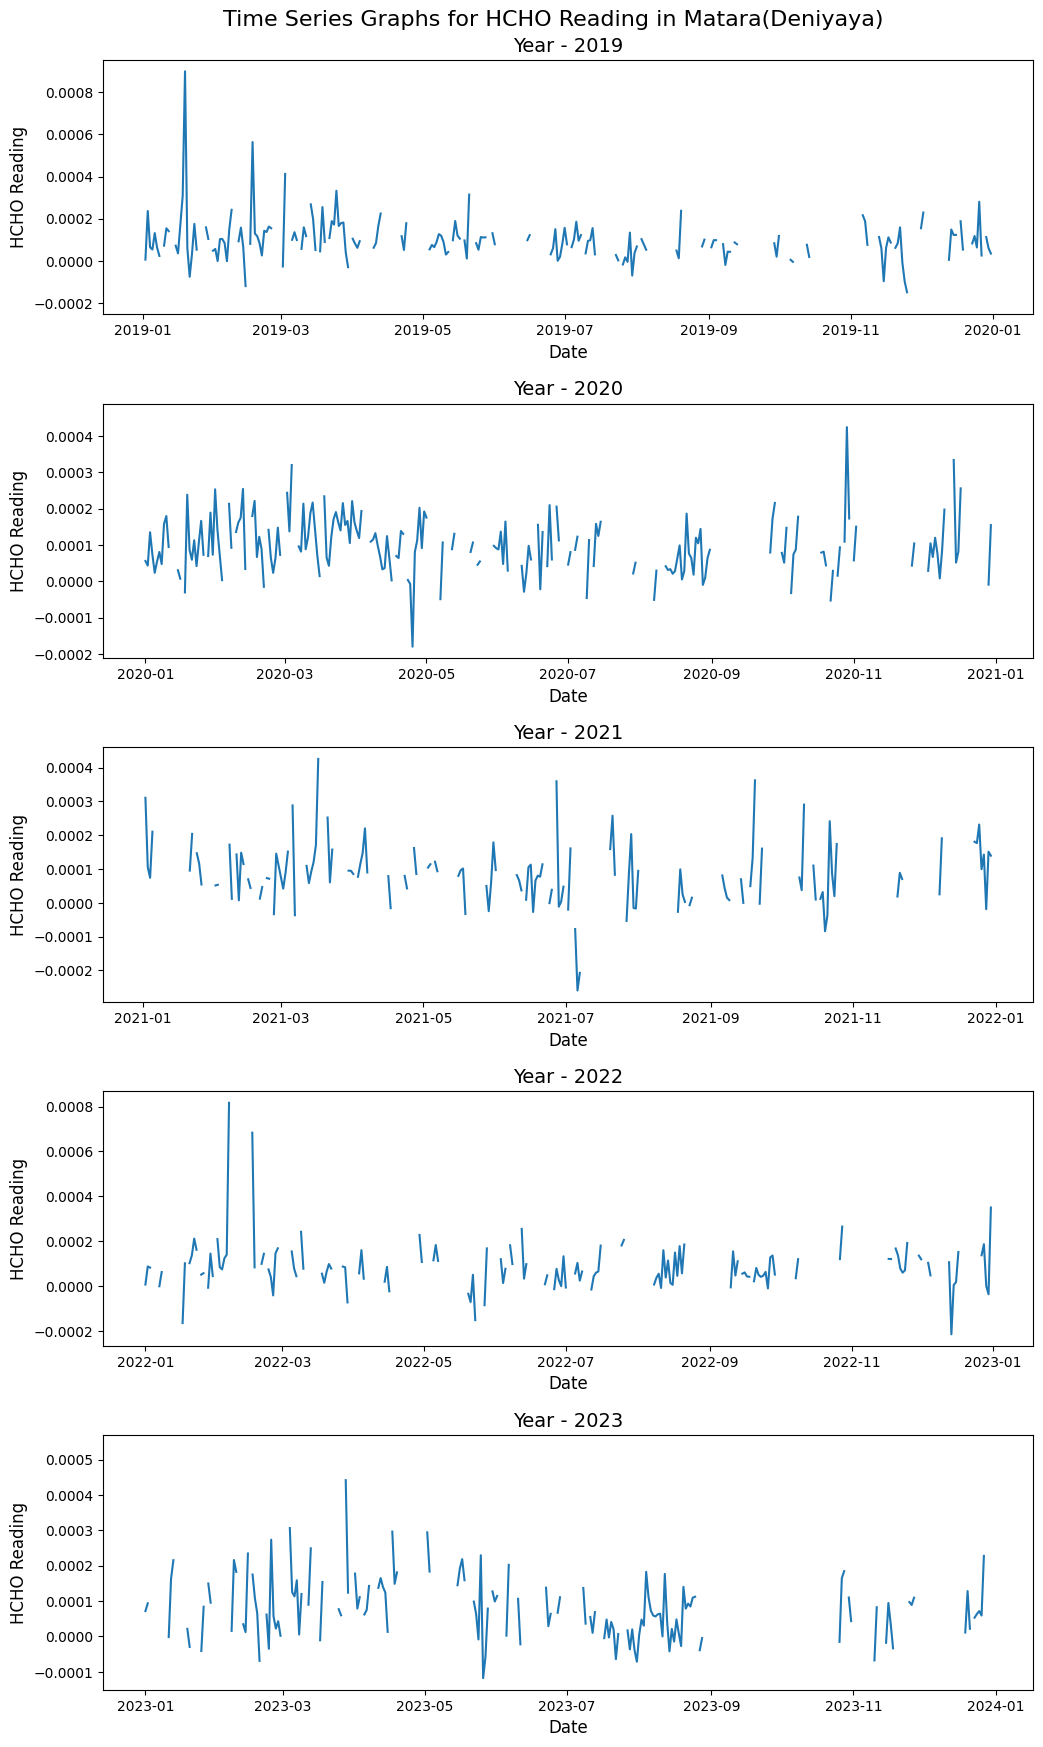

In [34]:
# Plot the time series graph for hcho_reading in Matara(Deniyaya) for each year

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle("Time Series Graphs for HCHO Reading in Matara(Deniyaya)", y=0.95, fontsize=16)

for year in years:
    axs[year-2019].plot(matara_proper.loc[f"{year}-01-01":f"{year}-12-31"].index,
                        matara_proper.loc[f"{year}-01-01":f"{year}-12-31"]["hcho_reading"])
    axs[year-2019].set_title(f"Year - {year}", fontsize=14)
    axs[year-2019].set_xlabel("Date", fontsize=12)
    axs[year-2019].set_ylabel("HCHO Reading", fontsize=12)

# Adjust the spacing between supertitle and subtitles
plt.subplots_adjust(top=0.925, hspace=0.35)
plt.show()

## After Converting Negative values into null values

In [7]:
# Number of null values in hcho_reading column in entire dataset
all_data.filter(F.col("hcho_reading").isNull()).count()

5427

In [8]:
# Number of null values in hcho_reading column for each location
all_data.groupBy("location").agg(F.count(F.when(F.isnull("hcho_reading"), "hcho_reading")).alias("null_values")).show()

+-------------------+-----------+
|           location|null_values|
+-------------------+-----------+
|       Kandy Proper|        901|
|   Deniyaya, Matara|        962|
|  Kurunegala Proper|        648|
| Bibile, Monaragala|        774|
|     Colombo Proper|        539|
|Nuwara Eliya Proper|       1181|
|      Jaffna Proper|        422|
+-------------------+-----------+



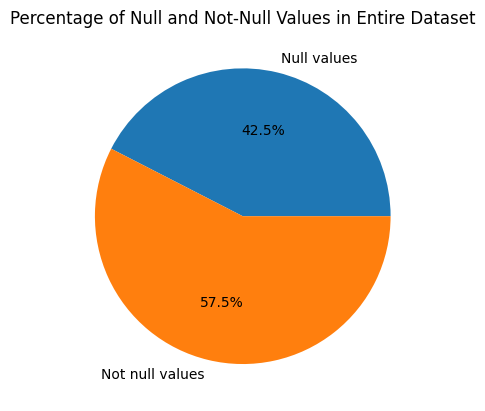

In [9]:
# Visulaize a pie chart with null values count for hcho_reading column in entire dataset
null_values_all = all_data.filter(F.col("hcho_reading").isNull()).count()
not_null_values_all = all_data.filter(F.col("hcho_reading").isNotNull()).count()

plt.pie([null_values_all, not_null_values_all], labels=["Null values", "Not null values"], autopct='%1.1f%%')
plt.title("Percentage of Null and Not-Null Values in Entire Dataset")
plt.show()

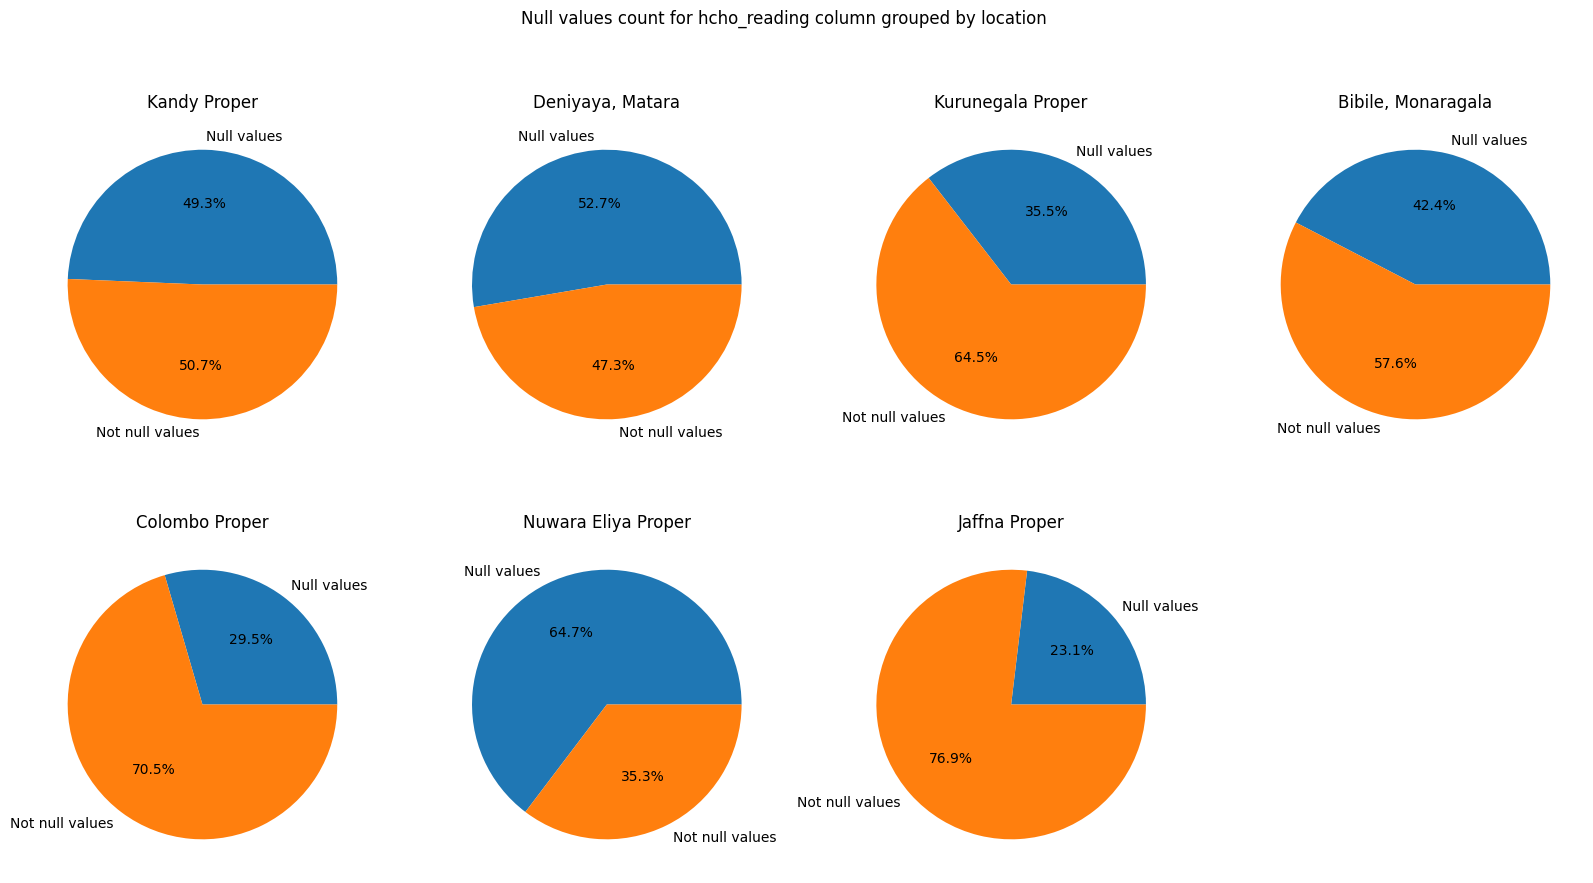

In [10]:
# Draw pie charts to look for null values grouped by location
null_values = all_data.filter(F.col("hcho_reading").isNull()).groupBy("location").count().toPandas()
not_null_values = all_data.filter(F.col("hcho_reading").isNotNull()).groupBy("location").count().toPandas()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Null values count for hcho_reading column grouped by location")

for i, ax in enumerate(axs.flat):
    if i < len(null_values):
        ax.pie([null_values["count"][i], not_null_values["count"][i]],
               labels=["Null values", "Not null values"], autopct='%1.1f%%')
        ax.set_title(null_values["location"][i])
    # Remove the last subplot
    else:
        fig.delaxes(ax)
    
plt.show()

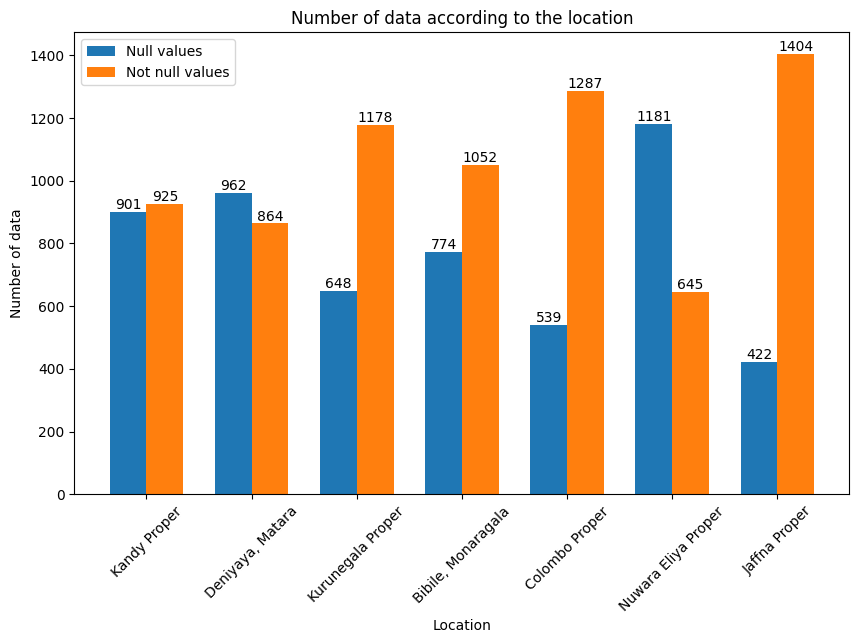

In [12]:
# Draw bar graph to visualize the distribution of null and not null values for each location
plt.figure(figsize=(10, 6))

# Set the x coordinates for the bars
x = np.arange(len(location_count["location"]))

# Plot the bars for null values
plt.bar(x - 0.35/2, null_values["count"], width=0.35, label='Null values')

# Plot the bars for not null values
plt.bar(x + 0.35/2, not_null_values["count"], width=0.35, label='Not null values')

plt.xlabel("Location")
plt.ylabel("Number of data")
plt.title("Number of data according to the location")
plt.xticks(x,location_count["location"],rotation=45)

# Add counts to each bar
for i, count in enumerate(location_count["count"]):
    plt.text(i - 0.35/2, null_values["count"][i], str(null_values["count"][i]), ha='center', va='bottom')
    plt.text(i + 0.35/2, not_null_values["count"][i], str(not_null_values["count"][i]), ha='center', va='bottom')

plt.legend()
plt.show()
